2024.06.04   
Q1:自动求导和反向传播的关系,为什么反向传播用在神经网络就更合适?                 
A:自动求导在计算机中是一种更有效的表示符合求导的方法，通过给定计算机一些规则，使用计算图来进行求导。可以使用反向模式或前向模式，神经网络通常是一个输出，用反向模式更高效    


Q2:如何将任意的数学表达式写为计算图的形式?数据结构的基本形式是什么?     
    A:通过递归的方式，在生成图节点变量中手动指定child node，leaf node默认没有child node


Q3:为什么要设置成梯度可加?          
    A:某一个节点可能在计算图中多次出现，防止梯度override    


    
Q4:每一个变量的grad是什么含义？     
    A:output node对每一个变量的global grad, 通过链式法则求得        

----

梯度是很重要的:

It tells us how A and B are affecting g through this mathematical expression
eg. dg/da , dg/db

Neural networks are just mathmatical expressions. They take the input data as input and they take the weights of the neural networks and the mathmetical expressions and output the predictions.

Basically neural networks just happen to be a certain class of mathmetical expressions, but back propagation is actually significantly more general. It doesn't care about neural network at all. It tells us about arbitrary mathmatical expressions and then we happen to use that machinery for training of neural networks.

核心知识点:
1. 自动求导，计算图
2. 反向传播，链式法则

PS : micrograd 实现了single value的autograd engine for pedagogical reasons. If you actually want to train bigger neural networks you have to be using these tensors but none of the math changes, this is done purely for efficiency. Micrograd is what you need to train your networks and everything else is just efficiency 


----


总结: 
1. 构建计算图：使用Value这种图数据结构来生成计算图。每一个Value都会wrap single value,重写add, mul, pow等函数,计算图的核心是在创建Value时保留一个_prev指针来指向之前的child变量
2. 为计算图的每一个node设置grad : grad是某一个final node 相对于所有节点的梯度,在计算时不仅要定义forward该怎么算，还需要定义这个操作的_backward函数怎么算。_backward函数计算是从parent node计算所有child node相对于final node的梯度, 使用链式法则，计算 child global grad += local derivitative * parent global derivitative。使用+是代表一个节点可能在计算图出现多次，使用了multivariate的chain rule。
3. DAG一定存在至少一种图拓扑排序，使用广度优先搜索排序之后，output.grad=1, 从root node for 循环使用_backward()函数, 最多进行O(N)次操作即可求得全部的梯度

4. 理解神经网络的bias通过对比神经元的激活 : innate trigger happiness

This is sort of innate trigger happiness of the neuron. This bias can make it a bit more trigger happy or a bit less trigger happy regardless of the input


-----


bias表示不论网络输入什么，神经元内在的是否容易被激活的特点

激活函数的作用：squashing, when the inputs come in , they get squashed on the y coordinates

weight可以看作synaptic strengths

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import math
import random

print('Pytorch version\t:', torch.__version__)
print('CUDA version\t:', torch.version.cuda)

for i in range(torch.cuda.device_count()):
    print(f'GPU{i}\t\t:',torch.cuda.get_device_name(i))

Pytorch version	: 2.2.2
CUDA version	: 12.1
GPU0		: NVIDIA GeForce RTX 4090


In [2]:
# numerical differentiation
x = 1
y = lambda x : x**2 + 3*x + 1
h = 0.0001
dy_dx = (y(x+h)-y(x)) / h
print(dy_dx)

5.000099999996621


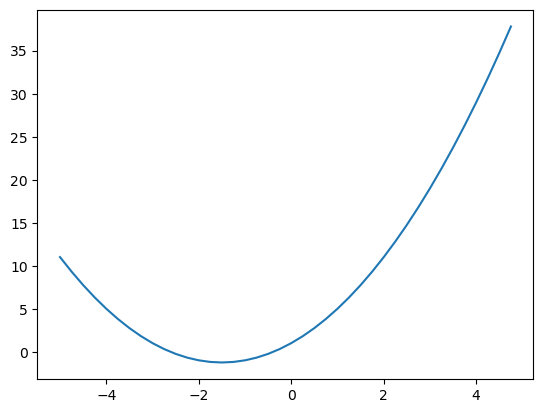

In [3]:
xs = np.arange(-5,5,0.25)
ys = y(xs)
plt.plot(xs,ys)

2024.06.05

neural networks will be pretty massive mathmetical expressions so we need some data structures that maintain these expressions.

第一步，将数学表达式拆分成graph，构建最基本的数据结构

特别的是在某个操作之后我们需要知道并且维护，what values produce other values --> _children

Now we know the children of  each value, but we don't know what operation created this value, we call this underscore op --> _op

In [4]:
x = (2,)
y = (2)

In [5]:
class Value:
    def __init__(self,data, _children=(), _op = '',label=""):
        self.data = data
        self.grad = 0.0 # zero means no affect
        self._backward = lambda: None # default backward function does't do anything, for example for a leaf node
        self._prev = set(_children) # DAG数据结构的核心,通过prev这个Pointer来指向child节点
        self._op = _op
        self.label = label

    
    # wrapper function to rerurn the string
    # 如果没有string的话，直接print某一个object的时候会返回一个地址---ugly expression
    # So what wrapper is doing is provding us a nicer looking expression in python
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # we have to use the special double underscore methods in python to define the operators for these objects
    def __add__(self,other):
        # 构建forward pass
        other = other if isinstance(other , Value) else Value(other) # 保证了Value(2) + 1的操作
        out = Value(self.data + other.data,(self,other),'+') # 加法操作之后，新的非叶子结点拥有两个child节点,分别是self和other这两个Value
        def _backward():
            # 通过闭包函数closure进行传递
            # 通过backward函数，将当前节点的grad传递给child节点
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other), '*')
        def _backward():
            # 乘法的Chain rule for multiplication
            self.grad += other.data * out.grad # local gradient * global gradient -> out.grad 表示dl/dp, self.grad 表示dl/dx
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other): # other * set
        # 如果 2 * a 报错，用a * 2是不是可行,此时会调用rmul函数, self.__rmul__(other)
        return self * other # 调用__mul__函数
    
    def __truediv__(self,other): # self / other
        return self * other ** -1
    
    def __neg__(self): # -other
        return self * -1
    
    def __sub__(self,other): # self-other
        return self + (-other)
    
    def __radd__(self,other): # other + self
        return self + other
    
    def __rneg__(self): # -self
        return self * -1
    
    def __rsub__(self,other): # other - self
        return other + (-self)
    
    def __rtrudiv__(self,other): # other / self
        return other * self ** -1

    def __pow__(self,other):
        # power 的other并不wrap位一个Value
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad 
        out._backward = _backward
        return out
    


    def tanh(self):
        # auto grad engine不在乎每个步骤是不是基础运算，只要定义出the derivative of the partent node with repsect to the child node即可---定义local grad
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t,(self,), 'tanh')    
        def _backward():
            self.grad += (1 - t**2) * out.grad # chain rule : local gradient * global gradient
        out._backward = _backward
        return out
    
    def relu(self):
        x = self.data
        out = Value(max(0,x),(self,), 'relu') # (self)会返回一个对象, (self,)是一个tuple
        def _backward():
            self.grad += (x > 0) * out.grad
        out._backward = _backward
        return out
    
        
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self, ),'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # build topological graph
        topo = []
        visitied = set()
        def build_topo(v):
            if v not in visitied:
                visitied.add(v)
                for child in v._prev:
                    build_topo(child) #
                topo.append(v) 
        build_topo(self)        
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

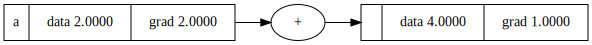

In [11]:
a = Value(2,label='a')
b = a + a
b.backward()
draw_dot(b)

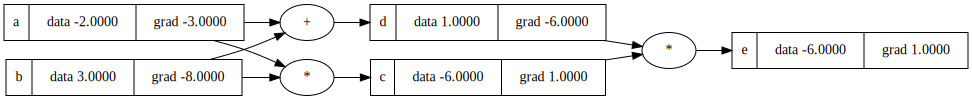

In [10]:
a = Value(-2,label='a')
b = Value(3,label='b')
c = a * b; c.label = 'c'
d = a + b; d.label = 'd'
e = c * d; e.label = 'e'
e.backward()
draw_dot(e)

In [8]:

a = Value(2,label='a')
b = Value(-3,label='b')
c = Value(10.0,label='c')
e = a * b ; e.label = 'e'
d = e + c ; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f ; L.label = 'L'

In [12]:
from graphviz import Digraph
# 注意draw dot中的符号node只表示一个操作，在计算机中并不是一个真正的Node
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [13]:
# dL/dd = f ; dL/df = d
# dL/dc = dL/dd * dd/dc = -2 *  1 = -2
# dL/de = dL/dd * dd/de = -2 * 1 = -2 

In [15]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
c.grad = -2 # 加法操作不影响grad; a plus node will simply disribute the derivative to all the children nodes
e.grad = -2

In [14]:
# dL/de = -2
# dL/da = dL/de * de/da = -2 * -3 = 6, de/da is just the local gradient
# dL/db = dL/de * de/db = -2 * 2 = -4
a.grad = -2.0 * -3.0
b.grad = -2.0 * -2.0

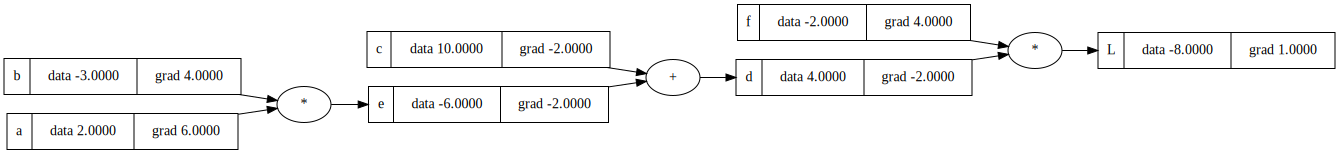

In [21]:
draw_dot(L)

理解神经网络的bias通过对比神经元的激活  

This is sort of innate trigger happiness of the neuron. This bias can make it a bit more trigger happy or a bit less trigger happy regardless of the input


bias表示不论网络输入什么，神经元内在的是否容易被激活的特点

激活函数的作用：squashing, when the inputs come in , they get squashed on the y coordinates

weight可以看作synaptic strengths

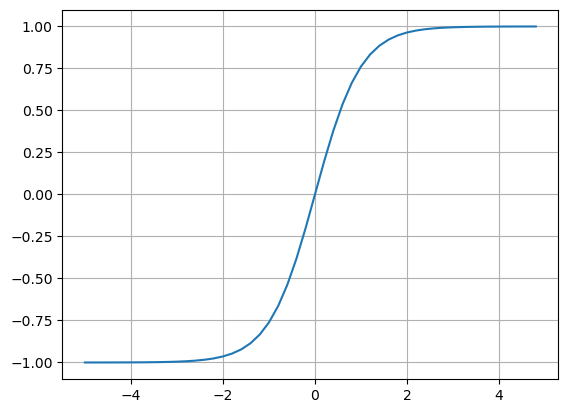

In [3]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));plt.grid()

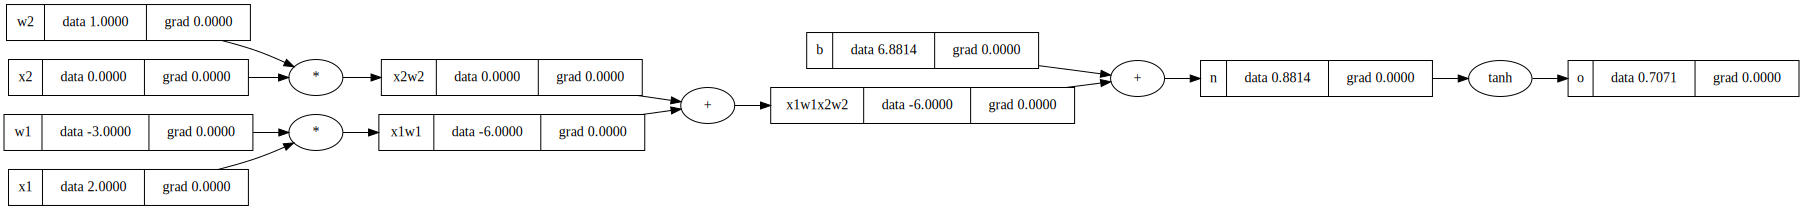

In [73]:
# inputs x1,x2 
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#  weights w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# biaas of the neuron
b = Value(6.8813735,label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1 ; x1w1.label = 'x1w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'
draw_dot(o)

In [74]:
o.backward()

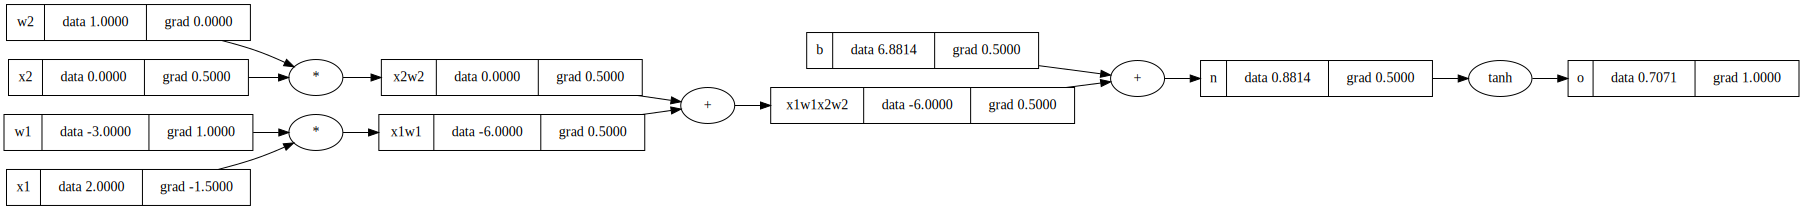

In [75]:
draw_dot(o)

In [24]:
o.grad = 1.0
n.grad = 0.5
b.grad = n.grad # plus operation just distributes the gradient
x1w1x2w2.grad = n.grad # plut operation
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
# o = tanh(n)
# do/dn = 1 - o**2

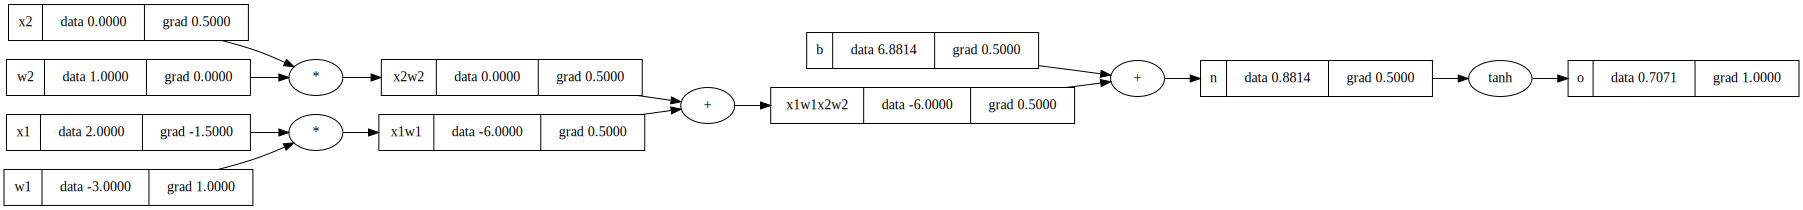

In [71]:
draw_dot(o)
# x2 = 0 ,因此w2是没有梯度的,w2怎么改变,在x2不变的情况下不影响final
# 这也就是为什么LoRA开始舒适化B=0, x!=0,则x的梯度不是0

目前需要手动调用所有的_backward(),可以wrap一下得到一个backward()函数

需要利用topological grap lay out this mathmetical expression (mathmetical graph) 

topological sort - 图的拓扑排序--> 有向图的排序, 使得对于所有的边(u,v)->u的顺序都在v之前

1. 图排序本质是一种图的遍历，只有某一个结点的所有子节点被访问到了，才可以访问这个节点（深度优先搜索算法）。Precisely, a topological sort is a graph traversal in which each node v is visited only after all its dependencies are visited


2. 只有图不存在有向环时，即有向无环图时，才可以进行拓扑排序。任何DAG都至少有一个拓扑排序，并且可以在线性时间内构造这样的拓扑排序

使用DFS之后，调用某一个非叶子结点a之后的全部_backward()，得到所有节点相对于a的梯度

In [98]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [99]:
e

ValueError(5.828426110372144, Value(data=1.7627469999999992), 'exp')

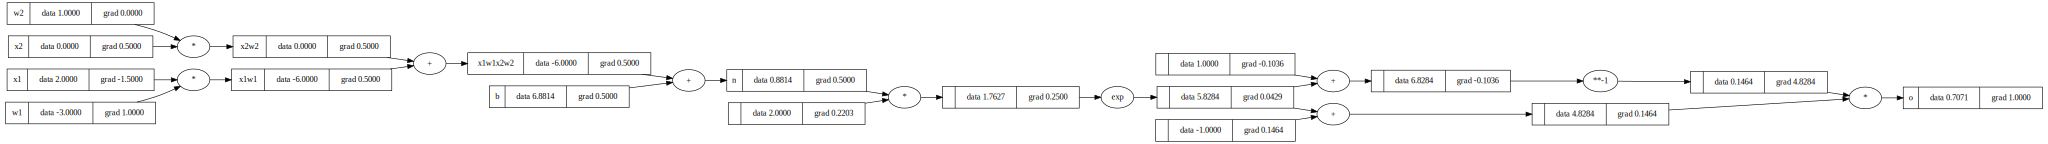

In [106]:
# inputs x1,x2 
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#  weights w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# biaas of the neuron
b = Value(6.8813735,label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1 ; x1w1.label = 'x1w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
# ----
e = (2*n).exp() 
o = (e-1)/(e+1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [112]:
# the same thing in pyroch : micrograd is a singular-value pytorch auto engine;
# pytorch cares about efficient
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735]).double() ; b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print(f"----")
print(f"b.grad = {b.grad.item()}")
print(f"w1.grad = {w1.grad.item()}")
print(f"w2.grad = {w2.grad.item()}")
print(f"x1.grad = {x1.grad.item()}")
print(f"x2.grad = {x2.grad.item()}")
print(f"----")

0.7071066904050358
----
b.grad = 0.5000001283844369
w1.grad = 1.0000002567688737
w2.grad = 0.0
x1.grad = -1.5000003851533106
x2.grad = 0.5000001283844369
----


In [205]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1)) # overall trigger happpiness of this neuron
    
    def __call__(self,x):
        act=  sum((wi*xi for wi, xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    # a layer is a set of independent neurons fully connected with the input data
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self,nin,nouts):
        # nouts is a list of neuron outputs
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.27228417739659566)

In [162]:
len(n.parameters())

41

In [206]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0, -1.0,-1.0,1.0]

In [198]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))
loss

Value(data=2.0549621647903687e-19)

In [199]:
loss.backward()

In [200]:
for p in n.parameters():
    p.data = p.data - 0.1 * p.grad # lr 太高，overstepped, explode the loss ; lr 太低收敛比较慢?

In [201]:
ypred

[Value(data=0.9999999995475949),
 Value(data=-0.9999999999767882),
 Value(data=-0.9999999999958367),
 Value(data=0.9999999999835771)]

In [207]:
for k in range(20):
    # zero the gradients
    for p in n.parameters():
        p.grad = 0.0
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))
    loss.backward()
    for p in n.parameters():
        p.data = p.data - 0.05 * p.grad
    print(f"{k},loss = {loss.data}")

0,loss = 7.49319659901094
1,loss = 5.413718234587512
2,loss = 4.420089108857154
3,loss = 3.8837634188339454
4,loss = 3.3213986924252894
5,loss = 2.5166892324418413
6,loss = 1.65139413229193
7,loss = 1.0010834580168022
8,loss = 0.6249497777599629
9,loss = 0.42456015101775435
10,loss = 0.31146082220597626
11,loss = 0.24190205209893612
12,loss = 0.1958220057102804
13,loss = 0.1634601193519999
14,loss = 0.13967476772387974
15,loss = 0.12155408753829483
16,loss = 0.10734523100116176
17,loss = 0.09593814591077993
18,loss = 0.08659948962143885
19,loss = 0.07882724848052167


为什么梯度是下降最快的方向？

利用x0处的一阶段泰勒展开

$f(x) = f(x_0)+ \nabla f(x_0) + (x-x_0)$ , $\nabla f(x_0) 与x-x_0$同方向时fx增加最大,反方向时f(x)减少最大

Andrej Karpathy提到最容易的三个bug
1. 尝试在小数据集上Overfit
2. 忘记打开train/eval Mode
3. 忘记在.backward()前Zero_grad()
4. 用softmax而不是raw logits